<a href="https://colab.research.google.com/github/NevroHelios/nn_practice/blob/main/Transformer_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import math

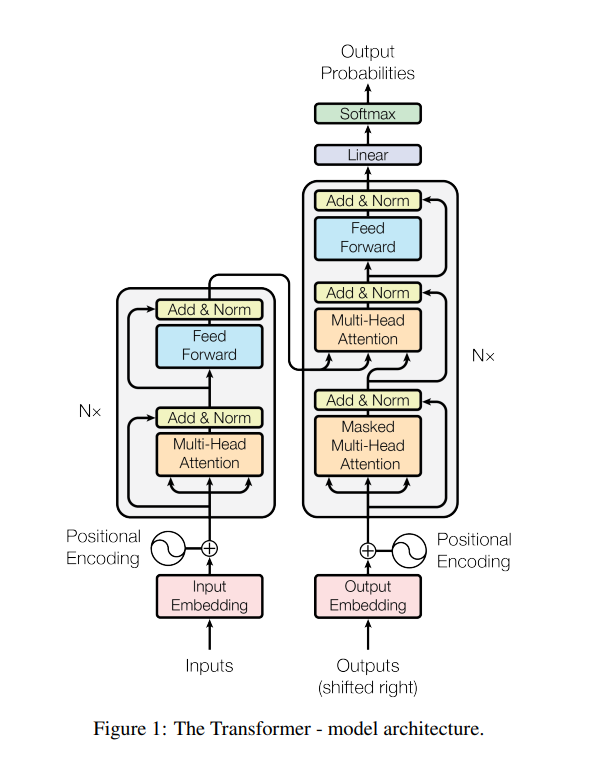

# Building the Transformer

### Input Embedding

In [ ]:
class InputEmbeddings(nn.Module):

  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model)

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, seq_len: int, dropout: float):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    # (pos, d_model)
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, seq_len, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe.unsqueeze(1) # (1, seq_len, d_mode)

    self.register_buffer('pe', pe)

  def forward(self, x):
    x  = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
    return self.dropout(x)

### Layer Normalisation

In [ ]:
class LayerNormalisation(nn.Module):

  def __init__(self, eps: float = 10**-6) -> None:
    super().__init__()
    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) # multiplied
    self.bias = nn.Parameter(torch.zeros(1)) # added

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim = -1, keepdim = True)
    return self.alpha * (x - mean) / (std * self.eps) + self.bias

### Feed Forward Block

In [ ]:
class FeedForwardBlock(nn.Module):

  def __init__(self, d_model: int, d_ff: int, dropout: float):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout)
    self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

### Multi Head Attention Block

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

  def __init__(self, d_model: int, h: int, dropout: float):
    super().__init__()
    self.d_model = d_model
    self.h = h
    assert d_model % h == 0, f'd_model: {d_model} is not divisible by h: {h}'

    self.d_k = d_model // h
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    self.w_0 = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  @staticmethod
  def Attention(query, key, value, mask, dropout: nn.Dropout):
    d_k = query.shape[-1]

    # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
    attention_scores = (query @ key.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
      attention_scores.masked_fills_(mask == 0, -1e9)
    attention_scores = attention_scores.softmax(dim = -1) # (batch, h, seq_len, seq_len)
    if dropout:
      attention_scores = dropout(attention_scores)

    return (attention_scores @ value), attention_scores

  def forward(self, q, k, v, mask):
    query = self.w_q(q)
    key = self.w_k(k)
    value = self.w_v(v)

    # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len , d_k)
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
    key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
    value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

    x, self.attention_scores = MultiHeadAttentionBlock.Attention(query, key, value, mask, self.dropout)
    # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_0(x)

### Residual Cennection

In [ ]:
class ResidualConnection(nn.Module):

  def __init__(self, dropout: float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalisation()

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

## Encoder Block

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, src_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
    x = self.residual_connections[1](x, self.feed_forward_block)

### Encoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalisation()

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

## Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
    x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
    x = self.residual_connections[2](x, self.feed_forward_block)
    return x

### Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers: nn.ModuleList):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalisation

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, src_mask, tgt_mask)
    return self.norm(x)

## Projection Layer

In [ ]:
class ProjectionLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int) -> None:
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    # (Batch, seq_len, d_model) --> (batch, seq_len, vocab_size)
    return torch.log_softmax(self.proj(x), dim = -1)

## Transformer

In [ ]:
class Transformer(nn.Module):

  def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.src_pos = src_pos
    self.tgt_pos = tgt_pos
    self.projection_layer = projection_layer

  def encode(self, src, src_mask):
    src = self.src_embed(src)
    src = self.src_pos(src)
    return self.encoder(src)

  def decode(self, encoder_output, src_mask, tgt, tgt_mask):
    tgt = self.tgt_embed(tgt)
    tgt = self.tgt_pos(tgt)
    return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

  def project(self, x):
    return self.projection_layer(x)

### Build Transformer

In [ ]:
def build_tranformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048):
  # create embedding layer
  src_embed = InputEmbeddings(d_model, src_vocab_size)
  tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

  # create the pos encoding
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

  # encoder block
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
    encoder_blocks.append(encoder_block)

  # decoder block
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
    decoder_blocks.append(decoder_block)

  # create encoder and decoder
  encoder = Encoder(nn.ModuleList(encoder_blocks))
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  # projection layer
  projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

  # create the transformer
  transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

  # Initialize the params
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer